<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20TMS%20pain%20timeseries%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tslearn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 7.5 MB/s eta 0:00:00


# Average Response timseries clustering

In [2]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pywt
from tslearn.clustering import TimeSeriesKMeans

# Load the data
link_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/tms_raw_data_timeseries.csv'
raw_data_ts = pd.read_csv(link_url, sep=';')

# --- Data Cleaning ---
# The data uses commas as decimal separators, replace them with dots and convert to float
float_columns = ['avg_respone_right', 'avg_respone_left', 'interstimul_threshod', 'inhibition_threshold_right', 'inhibition_threshold_left']
for col in float_columns:
    raw_data_ts[col] = raw_data_ts[col].replace(',', '.', regex=True)
    raw_data_ts[col] = pd.to_numeric(raw_data_ts[col], errors='coerce')


In [3]:
raw_data_ts = raw_data_ts.drop(['Unnamed: 7', 'Unnamed: 8'], axis=1)

In [41]:
raw_data_ts[raw_data_ts['patient_id'] == 'patient_ 20']

,patient_id,interstimul_interval,avg_respone_right,avg_respone_left,interstimul_threshod,inhibition_threshold_right,inhibition_threshold_left
228,patient_ 20,2,62.600000,70.271429,1.0,-1.4,-28.8
229,patient_ 20,3,106.255556,213.285714,1.5,-13.5,-23.0
230,patient_ 20,4,149.155556,236.285714,2.0,-8.4,-15.9
231,patient_ 20,5,129.688889,247.857143,2.5,-6.0,5.6
232,patient_ 20,6,151.044444,243.571429,3.0,-18.0,-13.2
233,patient_ 20,7,152.333333,277.428571,3.5,-9.1,-17.8
234,patient_ 20,8,130.655556,284.000000,4.0,-8.9,-15.9
235,patient_ 20,10,151.700000,221.714286,5.0,-14.2,-17.4
236,patient_ 20,12,156.500000,295.571429,7.0,-11.1,-22.5
237,patient_ 20,14,126.300000,249.714286,NaN,NaN,NaN


In [26]:
# drop patient_12 - it's a outcome
raw_data_ts_clean = []
raw_data_ts_clean = raw_data_ts[raw_data_ts['patient_id'] != 'patient_ 12']

#drop patient_26 and patient_31 and patient_20 (no data for average response)
raw_data_ts_clean = raw_data_ts[raw_data_ts['patient_id'] != 'patient_ 20']
raw_data_ts_clean = raw_data_ts[raw_data_ts['patient_id'] != 'patient_ 26']
raw_data_ts_clean = raw_data_ts[raw_data_ts['patient_id'] != 'patient_ 31']



raw_data_ts = raw_data_ts_clean

In [27]:

# --- Data Preparation ---
# Focus on complete cases for avg_respone_right and avg_respone_left
# Pivot data to get time series for each patient
columns_to_analyze = ['avg_respone_right', 'avg_respone_left']
data_for_analysis = raw_data_ts.dropna(subset=columns_to_analyze)

# Create a pivot table for each response variable
ts_data_right = data_for_analysis.pivot(index='patient_id', columns='interstimul_interval', values='avg_respone_right')
ts_data_left = data_for_analysis.pivot(index='patient_id', columns='interstimul_interval', values='avg_respone_left')

# Combine the two variables into a single multi-variate time series dataset
# Fill NaNs with a placeholder value (e.g., 0) if necessary, though dropping them above should avoid this
ts_data_combined = pd.concat([ts_data_right.add_suffix('_right'), ts_data_left.add_suffix('_left')], axis=1)
ts_data_clean = ts_data_combined.dropna() # Ensure no NaNs remain after combining

print(f"Shape of clean time series data (patients, time_points): {ts_data_clean.shape}")
print(f"Time points: {ts_data_clean.columns.tolist()}")

Shape of clean time series data (patients, time_points): (43, 24)
Time points: ['2_right', '3_right', '4_right', '5_right', '6_right', '7_right', '8_right', '10_right', '12_right', '14_right', '17_right', '20_right', '2_left', '3_left', '4_left', '5_left', '6_left', '7_left', '8_left', '10_left', '12_left', '14_left', '17_left', '20_left']


In [28]:
ts_data_clean.head(5)

interstimul_interval,2_right,3_right,4_right,5_right,6_right,7_right,8_right,10_right,12_right,14_right,...,4_left,5_left,6_left,7_left,8_left,10_left,12_left,14_left,17_left,20_left
patient_id,,,,,,,,,,,,,,,,,,,,,
patient_ 1,124.300000,95.240000,190.280000,156.400000,144.800000,141.160000,172.54,122.400000,163.500000,155.000000,...,75.740000,149.040000,153.040000,178.160000,190.400000,244.400000,179.480000,218.400000,277.000000,262.750000
patient_ 10,52.040000,27.825000,104.775000,152.575000,133.700000,275.000000,172.40,231.000000,278.250000,221.000000,...,24.354545,31.736364,40.309091,47.490909,51.354545,62.109091,52.218182,53.863636,59.445455,57.636364
patient_ 11,33.715000,186.333333,169.166667,181.200000,175.800000,166.000000,158.30,146.580000,146.280000,106.360000,...,124.066667,107.033333,105.283333,137.200000,153.633333,161.500000,166.833333,133.940000,78.100000,65.280000
patient_ 13,40.750000,46.383333,75.616667,94.666667,113.866667,102.816667,110.30,89.200000,138.983333,138.700000,...,26.816667,65.266667,62.033333,71.233333,93.933333,118.650000,99.050000,115.780000,92.560000,96.240000
patient_ 14,87.283333,91.600000,118.183333,181.500000,200.800000,221.900000,231.00,245.666667,201.000000,241.333333,...,39.633333,69.750000,92.950000,77.133333,99.416667,98.820000,96.400000,115.200000,145.400000,112.620000



--- Method 1: DWT Clustering ---
DWT clustering completed for 43 patients.

--- Method 2: DTW Clustering ---


/usr/local/lib/python3.12/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


DTW clustering completed for 43 patients.


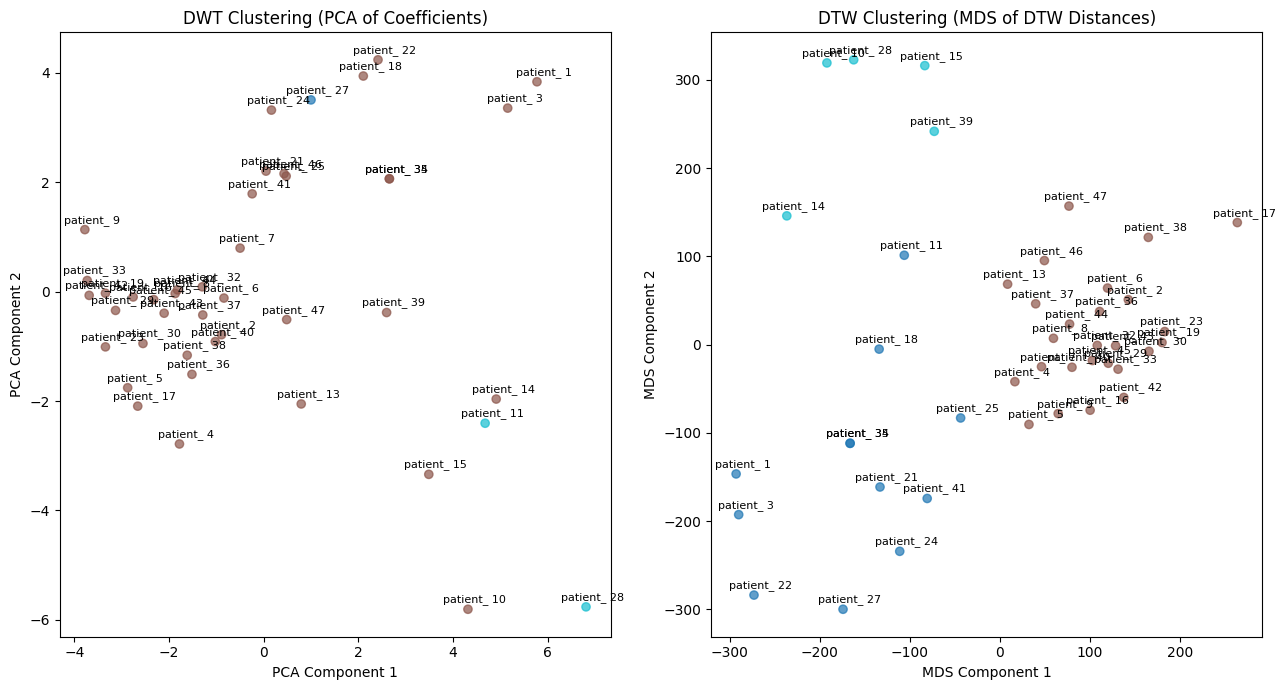


DWT Clustering Silhouette Score: 0.222
DTW Clustering Silhouette Score: 0.534


In [29]:


# --- Method 1: Discrete Wavelet Transform (DWT) Clustering ---
print("\n--- Method 1: DWT Clustering ---")
wavelet_coeffs = []
valid_indices = []
for idx in ts_data_clean.index:
    series = ts_data_clean.loc[idx].values
    # Check if series contains only NaNs or is invalid (though dropna above should prevent this)
    if not np.isnan(series).all() and len(series) > 0:
        # Perform DWT
        # The series length is 24. For 'db4' wavelet, level=2 is appropriate to avoid boundary effects.
        coeffs = pywt.wavedec(series, 'db4', level=2)
        # Flatten coefficients
        flat_coeffs = np.concatenate(coeffs)
        wavelet_coeffs.append(flat_coeffs)
        valid_indices.append(idx)
    else:
        print(f"Skipping patient {idx} due to invalid data.")

# Convert to numpy array
X_dwt = np.array(wavelet_coeffs)
if X_dwt.size > 0:
    scaler_dwt = StandardScaler()
    X_dwt_scaled = scaler_dwt.fit_transform(X_dwt)

    kmeans_dwt = KMeans(n_clusters=3, random_state=42)
    labels_dwt = kmeans_dwt.fit_predict(X_dwt_scaled)
    print(f"DWT clustering completed for {len(valid_indices)} patients.")
else:
    print("No valid data points found for DWT clustering.")
    labels_dwt = np.array([])
    X_dwt_scaled = np.array([]).reshape(0, 1) # Dummy array for plotting

# --- Method 2: Semi-Metric (Dynamic Time Warping - DTW) Clustering ---
print("\n--- Method 2: DTW Clustering ---")
# Use only the valid indices from DWT processing to ensure consistency
if len(valid_indices) > 0:
    ts_data_for_dtw = ts_data_clean.loc[valid_indices]
    # Prepare data for tslearn (shape: n_ts, n_timestamps, n_features)
    X_dtw = ts_data_for_dtw.values.reshape(ts_data_for_dtw.shape[0], ts_data_for_dtw.shape[1], 1)

    ts_km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=100, random_state=42)
    labels_dtw = ts_km_dtw.fit_predict(X_dtw)
    print(f"DTW clustering completed for {len(valid_indices)} patients.")
else:
    print("No valid data points found for DTW clustering.")
    labels_dtw = np.array([])
    X_dtw = np.array([]).reshape(0, 1, 1) # Dummy array for plotting

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

# DWT: Plot cluster centers in feature space (first 2 PCA components) if data exists
if X_dwt_scaled.size > 0 and X_dwt_scaled.shape[0] > 1: # Need more than one point for PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_dwt_pca = pca.fit_transform(X_dwt_scaled)
    scatter1 = axes[0].scatter(X_dwt_pca[:, 0], X_dwt_pca[:, 1], c=labels_dwt, cmap='tab10', alpha=0.7)
    axes[0].set_title("DWT Clustering (PCA of Coefficients)")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    #plt.colorbar(scatter1, ax=axes[0])

    # Add patient_id labels to the DWT PCA plot
    for i, patient_id in enumerate(valid_indices):
        axes[0].annotate(patient_id, (X_dwt_pca[i, 0], X_dwt_pca[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)


# DTW: Plot cluster centers in feature space (first 2 MDS components of DTW distance) if data exists
if X_dtw.shape[0] > 1: # Need more than one point for MDS
    from sklearn.manifold import MDS
    # Calculate DTW distance matrix
    n = X_dtw.shape[0]
    dtw_dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            from tslearn.metrics import dtw as tslearn_dtw
            dist = tslearn_dtw(X_dtw[i].squeeze(), X_dtw[j].squeeze())
            dtw_dist_matrix[i, j] = dist
            dtw_dist_matrix[j, i] = dist
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    X_dtw_mds = mds.fit_transform(dtw_dist_matrix)
    scatter2 = axes[1].scatter(X_dtw_mds[:, 0], X_dtw_mds[:, 1], c=labels_dtw, cmap='tab10', alpha=0.7)
    axes[1].set_title("DTW Clustering (MDS of DTW Distances)")
    axes[1].set_xlabel("MDS Component 1")
    axes[1].set_ylabel("MDS Component 2")
    #plt.colorbar(scatter2, ax=axes[1])

    # Add patient_id labels to the DTW MDS plot
    for i, patient_id in enumerate(valid_indices):
        axes[1].annotate(patient_id, (X_dtw_mds[i, 0], X_dtw_mds[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)


plt.tight_layout()
plt.show()

# Print Silhouette Scores (optional, requires distance matrices and more than one cluster)
from sklearn.metrics import silhouette_score
if len(np.unique(labels_dwt)) > 1 and X_dwt_scaled.size > 0 and X_dwt_scaled.shape[0] > 1:
    try:
        sil_score_dwt = silhouette_score(X_dwt_scaled, labels_dwt)
        print(f"\nDWT Clustering Silhouette Score: {sil_score_dwt:.3f}")
    except Exception as e:
        print(f"\nCould not calculate DWT Silhouette Score: {e}")
else:
    print("\nDWT Silhouette Score: Not calculated (insufficient data or clusters).")

if len(np.unique(labels_dtw)) > 1 and X_dtw.shape[0] > 1:
    try:
        sil_score_dtw = silhouette_score(dtw_dist_matrix, labels_dtw, metric='precomputed')
        print(f"DTW Clustering Silhouette Score: {sil_score_dtw:.3f}")
    except Exception as e:
        print(f"Could not calculate DTW Silhouette Score: {e}")
else:
    print("DTW Silhouette Score: Not calculated (insufficient data or clusters).")

## Visualize Individual Time Series for Each DTW Cluster

/tmp/ipython-input-4050208837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data_clean.loc[:, 'DTW_Cluster'] = dtW_cluster_series


Visualizing individual time series for each DTW cluster...


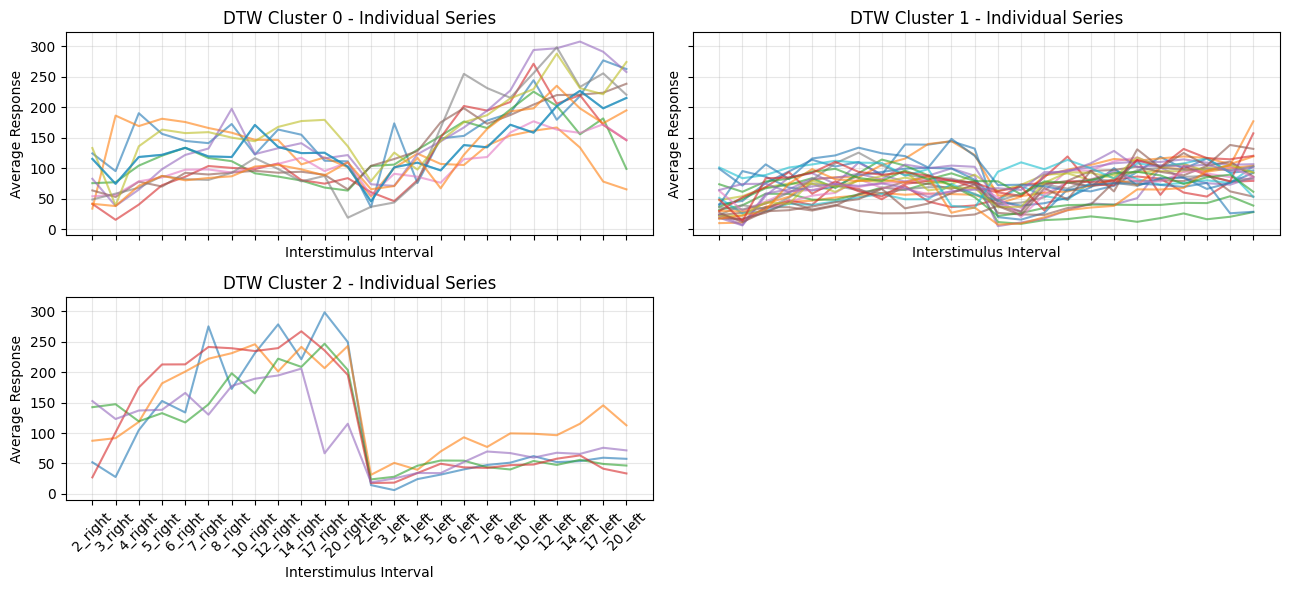

Individual time series visualizations for DTW clusters generated.


In [30]:
# Ensure DTW_Cluster is in ts_data_clean before proceeding
dtW_cluster_series = pd.Series(labels_dtw, index=valid_indices, name='DTW_Cluster')
ts_data_clean.loc[:, 'DTW_Cluster'] = dtW_cluster_series

# Get the columns that represent time series data, using ts_data_combined for robustness
ts_columns_for_plot = ts_data_combined.columns.tolist()

n_clusters = ts_data_clean['DTW_Cluster'].nunique()

# Determine the layout for subplots
rows = int(np.ceil(n_clusters / 2)) if n_clusters > 1 else 1
cols = 2 if n_clusters > 1 else 1

fig, axes = plt.subplots(rows, cols, figsize=(13, 3 * rows), sharex=True, sharey=True)
axes = axes.flatten() # Flatten the array of axes for easy iteration

print("Visualizing individual time series for each DTW cluster...")

for i in sorted(ts_data_clean['DTW_Cluster'].unique()):
    cluster_data = ts_data_clean[ts_data_clean['DTW_Cluster'] == i]

    ax = axes[i]
    for patient_id in cluster_data.index:
        ax.plot(ts_columns_for_plot, cluster_data.loc[patient_id, ts_columns_for_plot], alpha=0.6)

    ax.set_title(f'DTW Cluster {i} - Individual Series')
    ax.set_xlabel('Interstimulus Interval')
    ax.set_ylabel('Average Response')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(n_clusters, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Individual time series visualizations for DTW clusters generated.")

#Average inhibition threshold clustering


--- Method 1: DWT Clustering ---
DWT clustering completed for 45 patients.

--- Method 2: DTW Clustering ---


/usr/local/lib/python3.12/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


DTW clustering completed for 45 patients.


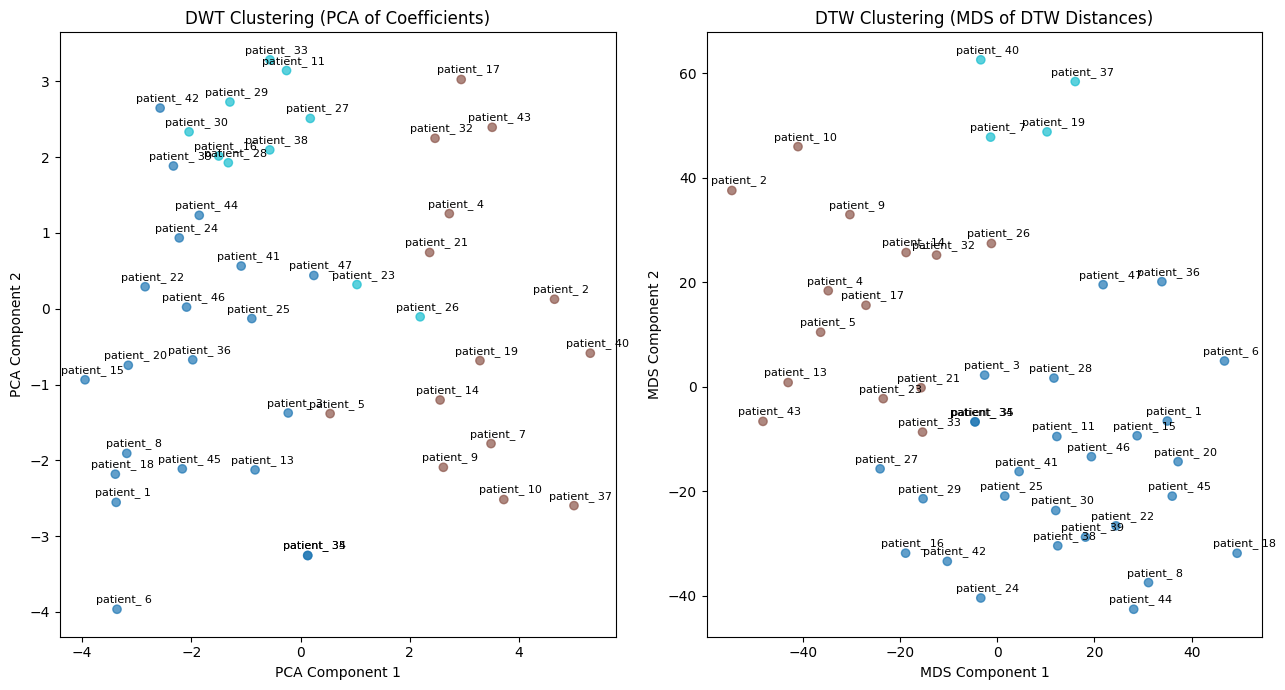


DWT Clustering Silhouette Score: 0.128
DTW Clustering Silhouette Score: 0.291


In [31]:
'''
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pywt
from tslearn.clustering import TimeSeriesKMeans

# Load the data
link_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/tms_raw_data_timeseries.csv'
raw_data_ts = pd.read_csv(link_url, sep=';')

# --- Data Cleaning ---
# The data uses commas as decimal separators, replace them with dots and convert to float
float_columns = ['avg_respone_right', 'avg_respone_left', 'interstimul_threshod', 'inhibition_threshold_right', 'inhibition_threshold_left']
for col in float_columns:
    raw_data_ts[col] = raw_data_ts[col].replace(',', '.', regex=True)
    raw_data_ts[col] = pd.to_numeric(raw_data_ts[col], errors='coerce')
'''
# --- Data Preparation ---
# Focus on complete cases for avg_respone_right and avg_respone_left
# Pivot data to get time series for each patient
columns_to_analyze = ['inhibition_threshold_right', 'inhibition_threshold_left']
data_for_analysis = []
data_for_analysis = raw_data_ts.dropna(subset=columns_to_analyze)

# Create a pivot table for each response variable
ts_data_right = []
ts_data_left = []
ts_data_right = data_for_analysis.pivot(index='patient_id', columns='interstimul_threshod', values='inhibition_threshold_right')
ts_data_left = data_for_analysis.pivot(index='patient_id', columns='interstimul_threshod', values='inhibition_threshold_left')

# Combine the two variables into a single multi-variate time series dataset
# Fill NaNs with a placeholder value (e.g., 0) if necessary, though dropping them above should avoid this
ts_data_combined = []
ts_data_clean = []
ts_data_combined = pd.concat([ts_data_right.add_suffix('_right'), ts_data_left.add_suffix('_left')], axis=1)
ts_data_clean = ts_data_combined.dropna() # Ensure no NaNs remain after combining

#print(f"Shape of clean time series data (patients, time_points): {ts_data_clean.shape}")
#print(f"Time points: {ts_data_clean.columns.tolist()}")

# --- Method 1: Discrete Wavelet Transform (DWT) Clustering ---
print("\n--- Method 1: DWT Clustering ---")
wavelet_coeffs = []
valid_indices = []
for idx in ts_data_clean.index:
    series = ts_data_clean.loc[idx].values
    # Check if series contains only NaNs or is invalid (though dropna above should prevent this)
    if not np.isnan(series).all() and len(series) > 0:
        # Perform DWT
        # The series length is 24. For 'db4' wavelet, level=2 is appropriate to avoid boundary effects.
        coeffs = pywt.wavedec(series, 'db4', level=2)
        # Flatten coefficients
        flat_coeffs = np.concatenate(coeffs)
        wavelet_coeffs.append(flat_coeffs)
        valid_indices.append(idx)
    else:
        print(f"Skipping patient {idx} due to invalid data.")

# Convert to numpy array
X_dwt = np.array(wavelet_coeffs)
if X_dwt.size > 0:
    scaler_dwt = StandardScaler()
    X_dwt_scaled = scaler_dwt.fit_transform(X_dwt)

    kmeans_dwt = KMeans(n_clusters=3, random_state=42)
    labels_dwt = kmeans_dwt.fit_predict(X_dwt_scaled)
    print(f"DWT clustering completed for {len(valid_indices)} patients.")
else:
    print("No valid data points found for DWT clustering.")
    labels_dwt = np.array([])
    X_dwt_scaled = np.array([]).reshape(0, 1) # Dummy array for plotting

# --- Method 2: Semi-Metric (Dynamic Time Warping - DTW) Clustering ---
print("\n--- Method 2: DTW Clustering ---")
# Use only the valid indices from DWT processing to ensure consistency
if len(valid_indices) > 0:
    ts_data_for_dtw = ts_data_clean.loc[valid_indices]
    # Prepare data for tslearn (shape: n_ts, n_timestamps, n_features)
    X_dtw = ts_data_for_dtw.values.reshape(ts_data_for_dtw.shape[0], ts_data_for_dtw.shape[1], 1)

    ts_km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=100, random_state=42)
    labels_dtw = ts_km_dtw.fit_predict(X_dtw)
    print(f"DTW clustering completed for {len(valid_indices)} patients.")
else:
    print("No valid data points found for DTW clustering.")
    labels_dtw = np.array([])
    X_dtw = np.array([]).reshape(0, 1, 1) # Dummy array for plotting

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

# DWT: Plot cluster centers in feature space (first 2 PCA components) if data exists
if X_dwt_scaled.size > 0 and X_dwt_scaled.shape[0] > 1: # Need more than one point for PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_dwt_pca = pca.fit_transform(X_dwt_scaled)
    scatter1 = axes[0].scatter(X_dwt_pca[:, 0], X_dwt_pca[:, 1], c=labels_dwt, cmap='tab10', alpha=0.7)
    axes[0].set_title("DWT Clustering (PCA of Coefficients)")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    #plt.colorbar(scatter1, ax=axes[0])

    # Add patient_id labels to the DWT PCA plot
    for i, patient_id in enumerate(valid_indices):
        axes[0].annotate(patient_id, (X_dwt_pca[i, 0], X_dwt_pca[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)


# DTW: Plot cluster centers in feature space (first 2 MDS components of DTW distance) if data exists
if X_dtw.shape[0] > 1: # Need more than one point for MDS
    from sklearn.manifold import MDS
    # Calculate DTW distance matrix
    n = X_dtw.shape[0]
    dtw_dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            from tslearn.metrics import dtw as tslearn_dtw
            dist = tslearn_dtw(X_dtw[i].squeeze(), X_dtw[j].squeeze())
            dtw_dist_matrix[i, j] = dist
            dtw_dist_matrix[j, i] = dist
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    X_dtw_mds = mds.fit_transform(dtw_dist_matrix)
    scatter2 = axes[1].scatter(X_dtw_mds[:, 0], X_dtw_mds[:, 1], c=labels_dtw, cmap='tab10', alpha=0.7)
    axes[1].set_title("DTW Clustering (MDS of DTW Distances)")
    axes[1].set_xlabel("MDS Component 1")
    axes[1].set_ylabel("MDS Component 2")
    #plt.colorbar(scatter2, ax=axes[1])

    # Add patient_id labels to the DTW MDS plot
    for i, patient_id in enumerate(valid_indices):
        axes[1].annotate(patient_id, (X_dtw_mds[i, 0], X_dtw_mds[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)


plt.tight_layout()
plt.show()

# Print Silhouette Scores (optional, requires distance matrices and more than one cluster)
from sklearn.metrics import silhouette_score
if len(np.unique(labels_dwt)) > 1 and X_dwt_scaled.size > 0 and X_dwt_scaled.shape[0] > 1:
    try:
        sil_score_dwt = silhouette_score(X_dwt_scaled, labels_dwt)
        print(f"\nDWT Clustering Silhouette Score: {sil_score_dwt:.3f}")
    except Exception as e:
        print(f"\nCould not calculate DWT Silhouette Score: {e}")
else:
    print("\nDWT Silhouette Score: Not calculated (insufficient data or clusters).")

if len(np.unique(labels_dtw)) > 1 and X_dtw.shape[0] > 1:
    try:
        sil_score_dtw = silhouette_score(dtw_dist_matrix, labels_dtw, metric='precomputed')
        print(f"DTW Clustering Silhouette Score: {sil_score_dtw:.3f}")
    except Exception as e:
        print(f"Could not calculate DTW Silhouette Score: {e}")
else:
    print("DTW Silhouette Score: Not calculated (insufficient data or clusters).")

# Compare two clustering results


Extract and align cluster labels (DTW and DWT) by patient ID from the 'average response' and 'inhibition threshold' analyses. Compute Adjusted Rand Index (ARI) to quantify the similarity between the two sets of DTW and DWT cluster labels. Finally, create two heatmaps to visualize the mapping of patients between DTW clusters and DWT clusters from both analyses.

In [32]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pywt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import adjusted_rand_score
import seaborn as sns

In [33]:
labels_dwt

array([0, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 0,
       2, 1, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1], dtype=int32)

In [34]:
labels_dtw

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0,
       1])

In [42]:
# --- Function to clean and prepare data (re-usable for both analyses) ---
def prepare_data(raw_data_df, columns_to_analyze, pivot_value_col, pivot_index_col):
    # The data uses commas as decimal separators, replace them with dots and convert to float
    float_columns = ['avg_respone_right', 'avg_respone_left', 'interstimul_threshod', 'inhibition_threshold_right', 'inhibition_threshold_left']
    for col in float_columns:
        raw_data_df[col] = raw_data_df[col].replace(',', '.', regex=True)
        raw_data_df[col] = pd.to_numeric(raw_data_df[col], errors='coerce')

    data_for_analysis = raw_data_df.dropna(subset=columns_to_analyze)

    # Create pivot tables for each response variable
    ts_data_right = data_for_analysis.pivot(index='patient_id', columns=pivot_index_col, values=columns_to_analyze[0])
    ts_data_left = data_for_analysis.pivot(index='patient_id', columns=pivot_index_col, values=columns_to_analyze[1])

    # Combine the two variables
    ts_data_combined = pd.concat([ts_data_right.add_suffix('_right'), ts_data_left.add_suffix('_left')], axis=1)
    ts_data_clean = ts_data_combined.dropna()
    return ts_data_clean

'''
# --- 2. For 'Average Response' analysis ---
print("Processing Average Response data...")
link_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/tms_raw_data_timeseries.csv'
raw_data_ts_avg_resp = pd.read_csv(link_url, sep=';')
'''

columns_to_analyze_avg_resp = ['avg_respone_right', 'avg_respone_left']
pivot_index_col_avg_resp = 'interstimul_interval'
#ts_data_clean_avg_resp = prepare_data(raw_data_ts_avg_resp.copy(), columns_to_analyze_avg_resp, 'avg_respone', pivot_index_col_avg_resp)
ts_data_clean_avg_resp = prepare_data(raw_data_ts_clean.copy(), columns_to_analyze_avg_resp, 'avg_respone', pivot_index_col_avg_resp)


# 2d. Perform DWT clustering for 'Average Response'
avg_resp_wavelet_coeffs = []
avg_resp_valid_indices = []
for idx in ts_data_clean_avg_resp.index:
    series = ts_data_clean_avg_resp.loc[idx].values
    if not np.isnan(series).all() and len(series) > 0:
        coeffs = pywt.wavedec(series, 'db4', level=2) # Using level=2 as before
        flat_coeffs = np.concatenate(coeffs)
        avg_resp_wavelet_coeffs.append(flat_coeffs)
        avg_resp_valid_indices.append(idx)

X_dwt_avg_resp = np.array(avg_resp_wavelet_coeffs)
scaler_dwt_avg_resp = StandardScaler()
X_dwt_scaled_avg_resp = scaler_dwt_avg_resp.fit_transform(X_dwt_avg_resp)

kmeans_dwt_avg_resp = KMeans(n_clusters=3, random_state=42) # Added n_init to suppress warning
avg_resp_labels_dwt = kmeans_dwt_avg_resp.fit_predict(X_dwt_scaled_avg_resp)

# 2e. The DTW cluster labels for average response are already available
# from the previous run in 'dtW_cluster_series'. Let's ensure it's properly named.
avg_resp_dtw_labels = dtW_cluster_series.copy()
avg_resp_dtw_labels.name = 'Avg_Resp_DTW_Cluster'

# --- 3. For 'Inhibition Threshold' analysis ---
print("Processing Inhibition Threshold data...")
# The variables `labels_dwt`, `labels_dtw`, and `valid_indices` in the kernel state
# currently hold the results from the *last* executed analysis, which was Inhibition Threshold.

# 3d. Extract DWT and DTW labels from the current kernel state
inh_thresh_dwt_labels = pd.Series(labels_dwt, index=valid_indices, name='Inh_Thresh_DWT_Cluster')
inh_thresh_dtw_labels = pd.Series(labels_dtw, index=valid_indices, name='Inh_Thresh_DTW_Cluster')

# --- 4. Align all cluster labels by patient ID ---
print("Aligning cluster labels...")
# Create series for average response DWT labels
avg_resp_dwt_labels_series = pd.Series(avg_resp_labels_dwt, index=avg_resp_valid_indices, name='Avg_Resp_DWT_Cluster')

# Combine all series into a single DataFrame
aligned_cluster_labels = pd.concat([
    avg_resp_dtw_labels,
    avg_resp_dwt_labels_series,
    inh_thresh_dtw_labels,
    inh_thresh_dwt_labels
], axis=1, join='outer')

# Fill NaNs with a placeholder, e.g., -1, for patients not present in a specific analysis
aligned_cluster_labels.fillna(-1, inplace=True)

print("Aligned Cluster Labels DataFrame:")
print(aligned_cluster_labels.head())
print(f"Shape of aligned_cluster_labels: {aligned_cluster_labels.shape}")

Processing Inhibition Threshold data...
Aligning cluster labels...
Aligned Cluster Labels DataFrame:
             Avg_Resp_DTW_Cluster  Avg_Resp_DWT_Cluster  \
patient_ 1                    0.0                   1.0   
patient_ 10                   2.0                   1.0   
patient_ 11                   0.0                   2.0   
patient_ 13                   1.0                   1.0   
patient_ 14                   2.0                   1.0   

             Inh_Thresh_DTW_Cluster  Inh_Thresh_DWT_Cluster  
patient_ 1                        0                       0  
patient_ 10                       1                       1  
patient_ 11                       0                       2  
patient_ 13                       1                       0  
patient_ 14                       1                       1  
Shape of aligned_cluster_labels: (45, 4)


/usr/local/lib/python3.12/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


The previous step successfully extracted and aligned the cluster labels. The next logical step, according to the task description, is to compute the Adjusted Rand Index (ARI) to quantify the similarity between the clusterings and then visualize the relationships with heatmaps. I will calculate ARI for relevant pairs of cluster labels and then generate the required heatmaps using the `aligned_cluster_labels` DataFrame.




--- Adjusted Rand Index (ARI) Scores ---
Average Response (DTW vs DWT): 0.119
Inhibition Threshold (DTW vs DWT): 0.458
DTW (Avg_Resp vs Inh_Thresh): -0.025
DWT (Avg_Resp vs Inh_Thresh): 0.083

--- Visualizing Cluster Mappings with Heatmaps ---


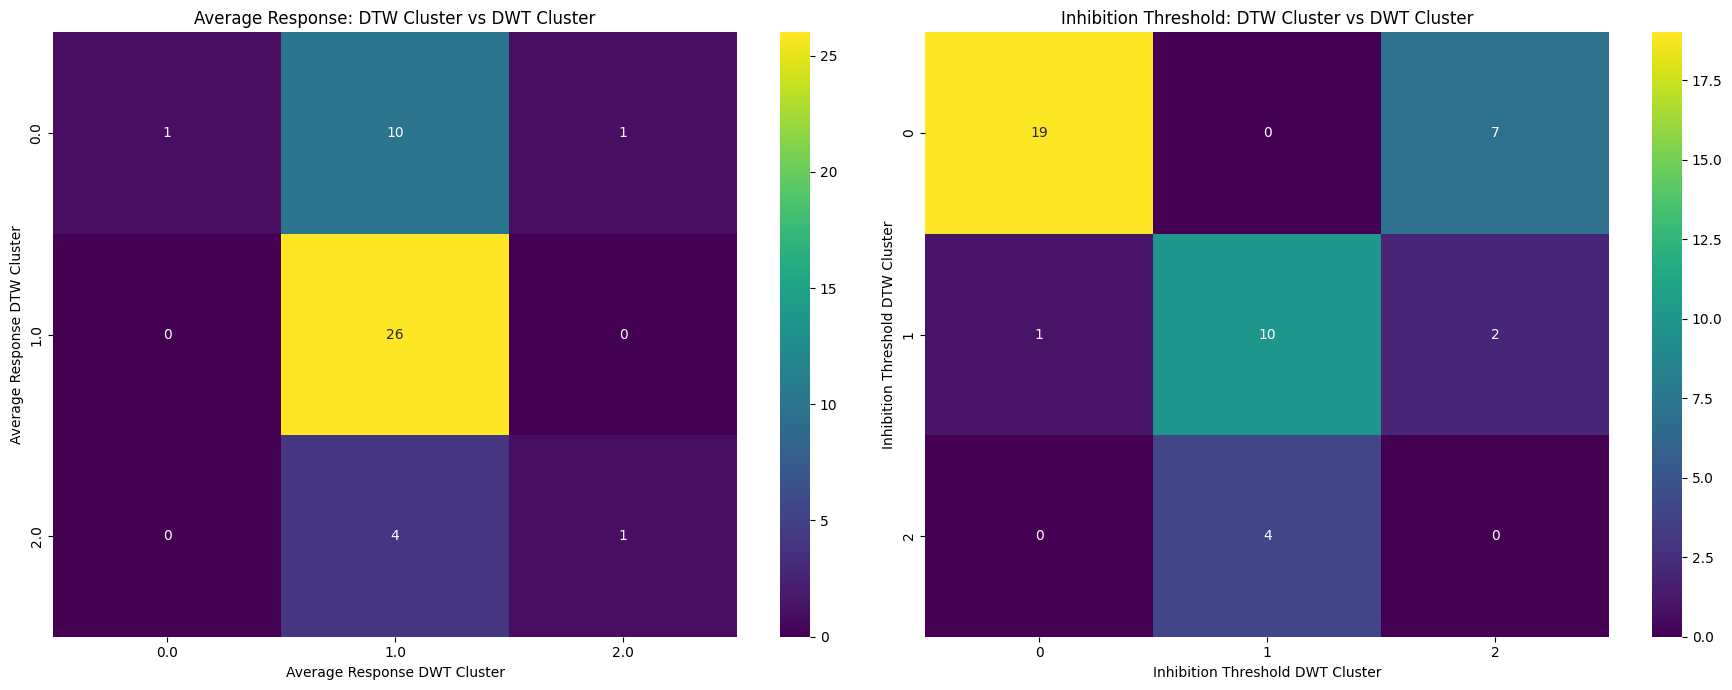

In [47]:
# Filter out patients not present in all analyses (those with -1 placeholder)
# For ARI calculation, we should only compare patients that are present in BOTH sets.
# For heatmaps, we can directly use the counts including -1 or exclude them if they are not meaningful clusters.

aligned_cluster_labels_filtered = aligned_cluster_labels[aligned_cluster_labels != -1].dropna()

print("\n--- Adjusted Rand Index (ARI) Scores ---")

def calculate_ari_for_non_negative_labels(labels_true, labels_pred):
    # Filter out -1 (missing) labels before calculating ARI
    valid_indices = (labels_true != -1) & (labels_pred != -1)
    if sum(valid_indices) < 2: # ARI requires at least two data points
        return np.nan
    return adjusted_rand_score(labels_true[valid_indices], labels_pred[valid_indices])

# ARI for Average Response: DTW vs DWT
ari_avg_resp_dtw_dwt = calculate_ari_for_non_negative_labels(
    aligned_cluster_labels_filtered['Avg_Resp_DTW_Cluster'],
    aligned_cluster_labels_filtered['Avg_Resp_DWT_Cluster']
)
print(f"Average Response (DTW vs DWT): {ari_avg_resp_dtw_dwt:.3f}")

# ARI for Inhibition Threshold: DTW vs DWT
ari_inh_thresh_dtw_dwt = calculate_ari_for_non_negative_labels(
    aligned_cluster_labels_filtered['Inh_Thresh_DTW_Cluster'],
    aligned_cluster_labels_filtered['Inh_Thresh_DWT_Cluster']
)
print(f"Inhibition Threshold (DTW vs DWT): {ari_inh_thresh_dtw_dwt:.3f}")

# ARI for DTW across analyses: Average Response DTW vs Inhibition Threshold DTW
ari_dtw_across_analyses = calculate_ari_for_non_negative_labels(
    aligned_cluster_labels_filtered['Avg_Resp_DTW_Cluster'],
    aligned_cluster_labels_filtered['Inh_Thresh_DTW_Cluster']
)
print(f"DTW (Avg_Resp vs Inh_Thresh): {ari_dtw_across_analyses:.3f}")

# ARI for DWT across analyses: Average Response DWT vs Inhibition Threshold DWT
ari_dwt_across_analyses = calculate_ari_for_non_negative_labels(
    aligned_cluster_labels_filtered['Avg_Resp_DWT_Cluster'],
    aligned_cluster_labels_filtered['Inh_Thresh_DWT_Cluster']
)
print(f"DWT (Avg_Resp vs Inh_Thresh): {ari_dwt_across_analyses:.3f}")

print("\n--- Visualizing Cluster Mappings with Heatmaps ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap 1: Average Response DTW vs Average Response DWT
# Use all original values for mapping, including -1 if present, to show full patient distribution
mapping_avg_resp = pd.crosstab(
    aligned_cluster_labels_filtered['Avg_Resp_DTW_Cluster'],
    aligned_cluster_labels_filtered['Avg_Resp_DWT_Cluster']
)
sns.heatmap(mapping_avg_resp, annot=True, fmt='d', cmap='viridis', ax=axes[0])
axes[0].set_title('Average Response: DTW Cluster vs DWT Cluster')
axes[0].set_xlabel('Average Response DWT Cluster')
axes[0].set_ylabel('Average Response DTW Cluster')

# Heatmap 2: Inhibition Threshold DTW vs Inhibition Threshold DWT
mapping_inh_thresh = pd.crosstab(
    aligned_cluster_labels_filtered['Inh_Thresh_DTW_Cluster'],
    aligned_cluster_labels_filtered['Inh_Thresh_DWT_Cluster']
)
sns.heatmap(mapping_inh_thresh, annot=True, fmt='d', cmap='viridis', ax=axes[1])
axes[1].set_title('Inhibition Threshold: DTW Cluster vs DWT Cluster')
axes[1].set_xlabel('Inhibition Threshold DWT Cluster')
axes[1].set_ylabel('Inhibition Threshold DTW Cluster')

plt.tight_layout()
plt.show()

## Visualize_Cross_Analysis_Cluster_Comparisons

Create heatmaps to visualize the mapping of patients between DTW clusters across analyses and DWT clusters across analyses.


**Reasoning**:
The subtask requires visualizing the mapping of patients between DTW clusters across analyses and DWT clusters across analyses using heatmaps. I will generate the heatmaps as instructed, leveraging the `aligned_cluster_labels` DataFrame from the previous step.



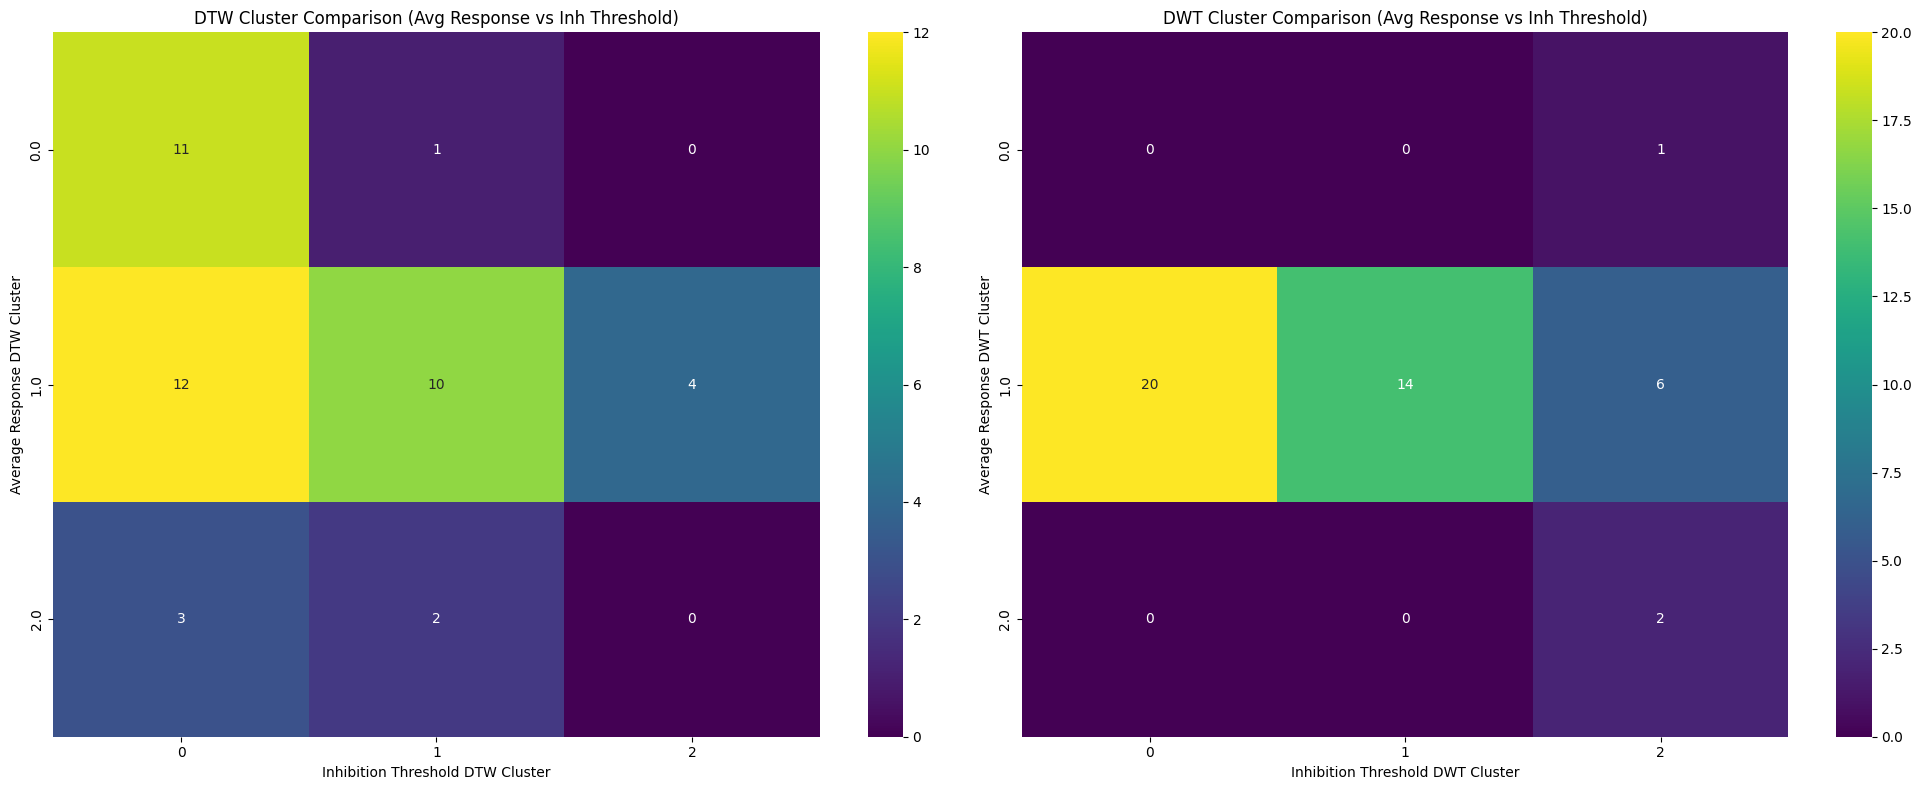

In [49]:

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: DTW Cluster Comparison (Average Response vs Inhibition Threshold)
mapping_dtw_cross_analysis = pd.crosstab(
    aligned_cluster_labels_filtered['Avg_Resp_DTW_Cluster'],
    aligned_cluster_labels_filtered['Inh_Thresh_DTW_Cluster']
)
sns.heatmap(mapping_dtw_cross_analysis, annot=True, fmt='d', cmap='viridis', ax=axes[0])
axes[0].set_title('DTW Cluster Comparison (Avg Response vs Inh Threshold)')
axes[0].set_xlabel('Inhibition Threshold DTW Cluster')
axes[0].set_ylabel('Average Response DTW Cluster')

# Heatmap 2: DWT Cluster Comparison (Average Response vs Inhibition Threshold)
mapping_dwt_cross_analysis = pd.crosstab(
    aligned_cluster_labels_filtered['Avg_Resp_DWT_Cluster'],
    aligned_cluster_labels_filtered['Inh_Thresh_DWT_Cluster']
)
sns.heatmap(mapping_dwt_cross_analysis, annot=True, fmt='d', cmap='viridis', ax=axes[1])
axes[1].set_title('DWT Cluster Comparison (Avg Response vs Inh Threshold)')
axes[1].set_xlabel('Inhibition Threshold DWT Cluster')
axes[1].set_ylabel('Average Response DWT Cluster')

plt.tight_layout()
plt.show()


# look from DFA to find the time when inhibition start

# Collect dataframe for result clustering

In [50]:
raw_data_ts_clean.head(5)

,patient_id,interstimul_interval,avg_respone_right,avg_respone_left,interstimul_threshod,inhibition_threshold_right,inhibition_threshold_left
0,patient_ 1,2,124.30,35.95,1.0,-0.6,-7.8
1,patient_ 1,3,95.24,173.60,1.5,-24.3,-8.0
2,patient_ 1,4,190.28,75.74,2.0,-20.6,3.8
3,patient_ 1,5,156.40,149.04,2.5,-9.1,2.2
4,patient_ 1,6,144.80,153.04,3.0,-0.6,-8.0


In [55]:
unique_patient_ids = raw_data_ts_clean['patient_id'].unique()
result_clustering = pd.DataFrame(unique_patient_ids, columns=['patient_id'])

# Ensure the label series are DataFrames for merging and have appropriate column names
avg_resp_dtw_labels_df = avg_resp_dtw_labels.reset_index()
avg_resp_dtw_labels_df.columns = ['patient_id', 'DTW_Average_Response_Labels']

inh_thresh_dtw_labels_df = inh_thresh_dtw_labels.reset_index()
inh_thresh_dtw_labels_df.columns = ['patient_id', 'DTW_Inhibition_Threshold_Labels']

# Merge the labels into the result_clustering DataFrame
result_clustering = pd.merge(result_clustering, avg_resp_dtw_labels_df, on='patient_id', how='left')
result_clustering = pd.merge(result_clustering, inh_thresh_dtw_labels_df, on='patient_id', how='left')

print(result_clustering.head())

   patient_id  DTW_Average_Response_Labels  DTW_Inhibition_Threshold_Labels
0  patient_ 1                          0.0                                0
1  patient_ 2                          1.0                                1
2  patient_ 3                          0.0                                0
3  patient_ 4                          1.0                                1
4  patient_ 5                          1.0                                1
